<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

Download the nessesary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool

# Downloading data

In [2]:
train_data = pd.read_csv('../input/advanced-dls-spring-2021/train.csv')
test_data = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')

Let's look at the data.

In [3]:
train_data.head(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
6,27,90.15,2423.4,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),0
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

It seems that there are no any gaps in both train and test datasets. But this is not true. If we examine each column more closely, we will notice that **TotalSpent** column contains empty strings that are not NaN. Let's replace them with NaN.

In [5]:
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
test_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')

In [6]:
df_nan = pd.concat([train_data.isna().sum()[:-1], test_data.isna().sum()], axis=1)
df_nan.columns = ['Train', 'Test']
df_nan

,Train,Test
ClientPeriod,0,0
MonthlySpending,0,0
TotalSpent,9,2
Sex,0,0
IsSeniorCitizen,0,0
HasPartner,0,0
HasChild,0,0
HasPhoneService,0,0
HasMultiplePhoneNumbers,0,0
HasInternetService,0,0


Now we have 9 gaps in train set and only 2 gaps in test set.

# Data exploration

## Feature type analysis

In [7]:
train_data.nunique()

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4977
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
dtype: int64

In [8]:
num_features = [*train_data.nunique()[train_data.nunique() > 5].index]
cat_features = [*train_data.nunique()[train_data.nunique() < 5].index][:-1]
bin_features = [*train_data.nunique()[train_data.nunique() == 2].index][:-1]

We can see that almost all the columns are categorical (and some of categorical are binary), only the first three columns are numeric.

## Data visualization

Let's look at numeric features.

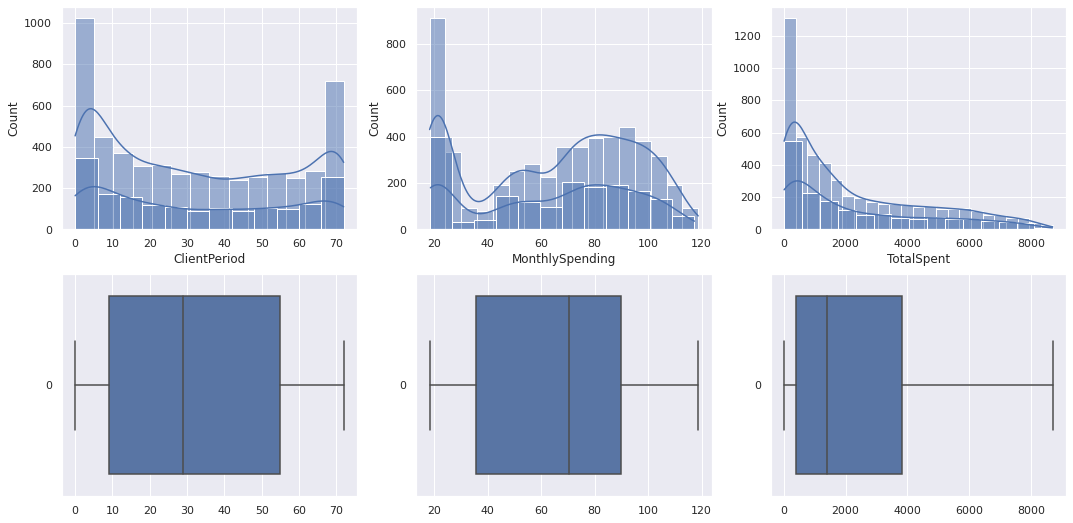

In [9]:
sns.set()
_, axes = plt.subplots(2, len(num_features), figsize=(18, 9))
for i in range(len(num_features)):
    sns.histplot(data=train_data[num_features[i]], ax=axes[0][i], kde=True)
    sns.histplot(data=test_data[num_features[i]], ax=axes[0][i], kde=True)
    
for i in range(len(num_features)):
    sns.boxplot(data=train_data[num_features[i]], ax=axes[1][i], orient='h')

We see that numeric features have almost the same distribution for test and train set.

Now let's look at binary and categorical features.

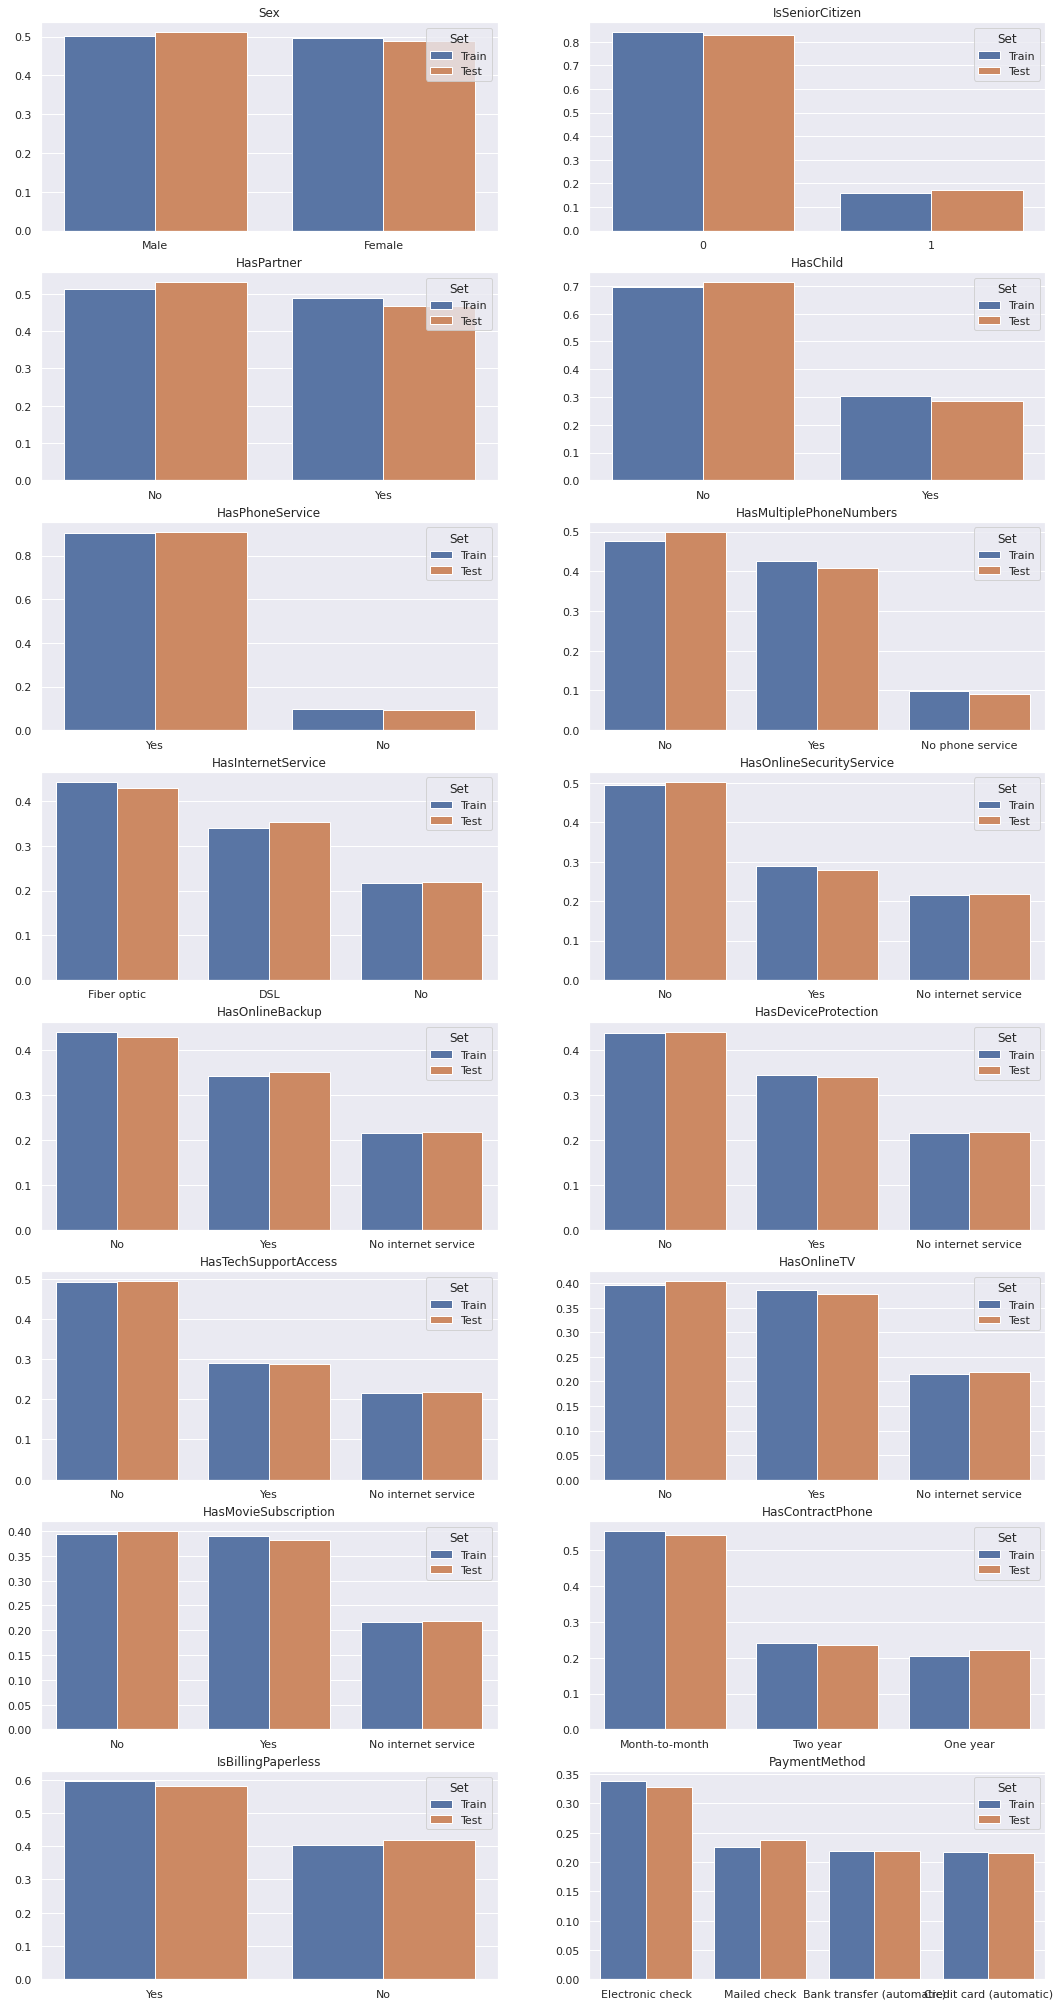

In [10]:
_, axes = plt.subplots(len(cat_features) // 2, 2, figsize=(18, 36))

for i in range(len(cat_features)):
    
    j = i // 2
    k = i % 2
    axis = axes[j][k]
    feature = cat_features[i]
    
    cat_train_data = train_data[feature].value_counts() / len(train_data)
    cat_train_data = pd.DataFrame(cat_train_data)
    cat_train_data['Set'] = 'Train'
    cat_test_data = test_data[feature].value_counts() / len(test_data)
    cat_test_data = pd.DataFrame(cat_test_data)
    cat_test_data['Set'] = 'Test'
    cat_data = pd.concat([cat_train_data, cat_test_data])
    
    sns.barplot(data=cat_data, ax=axis, x=cat_data.index, y=feature, hue='Set')
    axis.set(title=feature, ylabel=None)

Categorical features also have almost the same distribution for test and train data.

Let's look at target column.

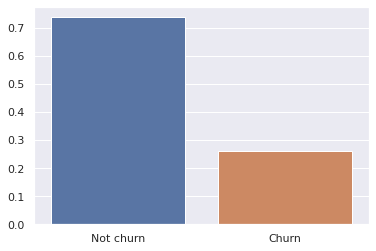

In [11]:
target_data = train_data['Churn'].value_counts() / len(train_data)
target_data = pd.DataFrame(target_data).transpose()
target_data.columns = ['Not churn', 'Churn']

sns.barplot(data=target_data);

We see that target column have some imbalance, but this is not critical because we still have enough examples of the positive class.

## Correlation visualization
Take a look at the correlation of parameters with the target column and with each other.

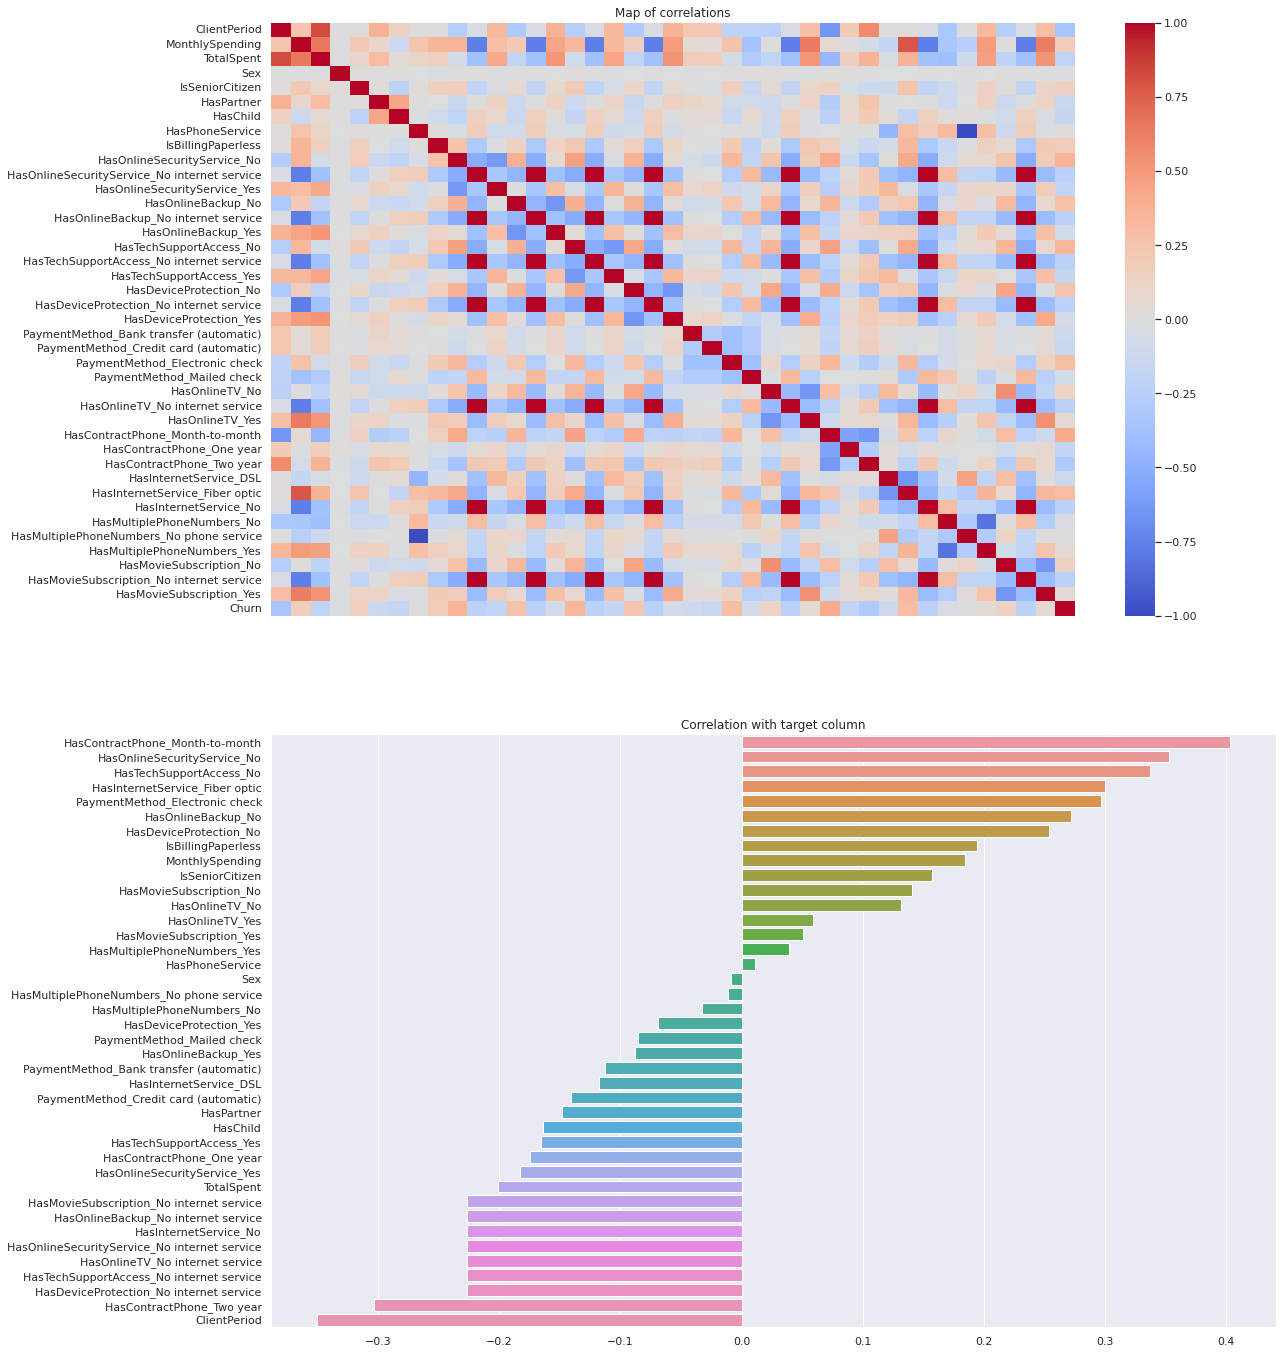

In [12]:
_, axes = plt.subplots(2, 1, figsize=(18, 24))
cols = list(set(cat_features) - set(bin_features))
df = pd.concat([pd.get_dummies(train_data.iloc[:, :-1], columns=cols), train_data.iloc[:, -1]], axis=1)
df['Sex'] = (df['Sex'] == 'Male').astype(int)
df[bin_features[2:]] = (df[bin_features[2:]] == 'Yes').astype(int)
sns.heatmap(df.corr(), cmap='coolwarm', ax=axes[0])
axes[0].set(xticklabels=[], title='Map of correlations')

df = pd.DataFrame(df.iloc[:, :-1].corrwith(df.iloc[:, -1]).sort_values(ascending=False)).transpose()
sns.barplot(data=df, ax=axes[1], orient='h')
axes[1].set(title='Correlation with target column');

## Data cleaning
At last, get rid of the gaps in TotalSpent column.

In [13]:
train_data['TotalSpent'].fillna(0, inplace=True)
test_data['TotalSpent'].fillna(0, inplace=True)

Now, we are ready to build a model.

# Logistic regression model

# Data preprocessing
For logistic regression we need to transform categoric features to one-hot vectors and to normalize numeric features.

In [14]:
cols = list(set(cat_features) - set(bin_features))
df = pd.concat([pd.get_dummies(train_data.iloc[:, :-1], columns=cols), train_data.iloc[:, -1]], axis=1).sample(frac=1)
df['Sex'] = (df['Sex'] == 'Male').astype(int)
df[bin_features[2:]] = (df[bin_features[2:]] == 'Yes').astype(int)

X_train = df.iloc[:-1000, :-1]
Y_train = df.iloc[:-1000, -1]
X_val = df.iloc[-1000:, :-1]
Y_val = df.iloc[-1000:, -1]

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

## Model search
Now we will use grid search to find the best params for model.

In [15]:
param_grid = {'C': [10 ** i for i in range(-3, 3)], 'max_iter': [1000]}

search = GridSearchCV(LogisticRegression(), param_grid, scoring=make_scorer(roc_auc_score), cv=5)
search.fit(X_train, Y_train)

params = search.best_params_
print(f'The best params: {params}')

The best params: {'C': 100, 'max_iter': 1000}


Apply the found parameters to our model.

In [16]:
linear_model = LogisticRegression()
linear_model.set_params(**params)
linear_model.fit(X_train, Y_train)
Y_val_pred = linear_model.predict_proba(X_val)[:, 1]
print(f'Validation ROC-AUC: {roc_auc_score(Y_val, Y_val_pred)}')

Validation ROC-AUC: 0.8447630277829495


We have ROC-AUC about 0.84 with C=100 **(the results may be different: it depends on randomness)**. It is really good perfomance for such simple model.

# Gradient Boosting model

# Data preprocessing
Now we will use CatBoostClassifier as our second model. This model doesn't need to preprocessing data. In addition, this algorithm shows good results without hyperparameter tuning.

In [17]:
df = train_data.sample(frac=1)
X_train = df.iloc[:-1000, :-1]
Y_train = df.iloc[:-1000, -1]
X_val = df.iloc[-1000:, :-1]
Y_val = df.iloc[-1000:, -1]

train_dataset = Pool(X_train, Y_train, cat_features)
val_dataset = Pool(X_val, Y_val, cat_features)

## Default CatBoostClassifier
Let's try model with default parameters.

In [18]:
model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', logging_level='Silent')
model.fit(train_dataset, use_best_model=True, eval_set=val_dataset)
print(f'Validation ROC-AUC: {roc_auc_score(Y_val, model.predict_proba(val_dataset)[:, 1])}')

Validation ROC-AUC: 0.8517835178351784


We have the score about 0.84 **(the results may be different: it depends on randomness)**. This is better than logistic regression.

## Grid search for CatBoostClassifier
Also use grid search to find the best params for the model.

In [19]:
param_grid = {'depth': [2, 3, 4],
              'learning_rate': [0.02, 0.03, 0.04]}

In [20]:
model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', logging_level='Silent', early_stopping_rounds=100)
search = model.grid_search(param_grid, train_dataset, cv=5)
print(search['params'])
print(f'Validation ROC-AUC: {roc_auc_score(Y_val, model.predict_proba(val_dataset)[:, 1])}')

0:	loss: 0.8489701	best: 0.8489701 (0)	total: 4.82s	remaining: 38.6s
1:	loss: 0.8485046	best: 0.8489701 (0)	total: 7.54s	remaining: 26.4s
2:	loss: 0.8513235	best: 0.8513235 (2)	total: 12.1s	remaining: 24.1s
3:	loss: 0.8488349	best: 0.8513235 (2)	total: 16.5s	remaining: 20.6s
4:	loss: 0.8486510	best: 0.8513235 (2)	total: 19.5s	remaining: 15.6s
5:	loss: 0.8470746	best: 0.8513235 (2)	total: 22s	remaining: 11s
6:	loss: 0.8482381	best: 0.8513235 (2)	total: 26.4s	remaining: 7.53s
7:	loss: 0.8498221	best: 0.8513235 (2)	total: 32.7s	remaining: 4.09s
8:	loss: 0.8493567	best: 0.8513235 (2)	total: 35.6s	remaining: 0us
Estimating final quality...
{'depth': 2, 'learning_rate': 0.04}
Validation ROC-AUC: 0.8561442404547502


## Model selection

Our score - about 0.85 with depth=3 and learning_rate=0.03 **(the results may be different: it depends on randomness)**. How we can see, after the grid search our result is some better than default one (although CatBoost can automatically find the best learning rate with default hyperparameters). Therefore, we will use the last model.

# Submission

Make prediction for test data.

In [21]:
X_test = test_data
Y_pred = model.predict_proba(X_test)[:, 1]

And make submission to competition.

In [22]:
submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = Y_pred
submission.to_csv('submission.csv', index=False)

# P.S.

Для проверяющих: 
* team name этого notebook'a - Dmitry_Malikov
* score = 0.85091

And thanks for reading this stuff!